We will code that

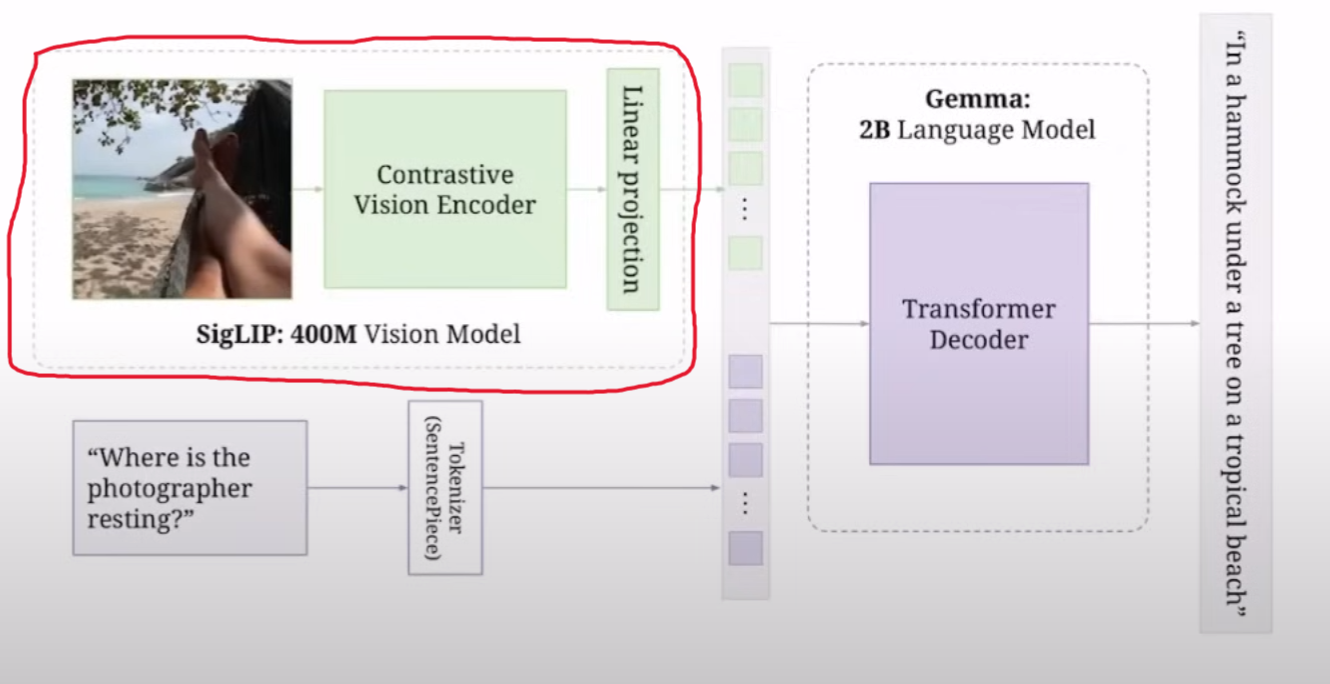

In [ ]:
from typing import Optional, Tuple
import torch
import torch.nn as nn

## SiglipVisionConfig

In [ ]:
class SiglipVisionConfig:
    def __init__(self,
          hidden_size=768,
          intermediate_size=3072,
          num_hidden_layers=12,
          num_attention_heads=12,
          num_channels=3, # R-G-B
          image_size=224,
          patch_size=16, # each image wil be divided by 16x16
          layer_norm_eps=1e-6,
          attention_dropout=0.0,
          num_image_tokens: int = None,
          **kwargs):
      super().__init__()
      self.hidden_size = hidden_size
      self.intermediate_size = intermediate_size
      self.num_hidden_layers = num_hidden_layers
      self.num_attention_heads = num_attention_heads
      self.num_channels = num_channels
      self.image_size = image_size
      self.patch_size = patch_size
      self.layer_norm_eps = layer_norm_eps
      self.attention_dropout = attention_dropout
      self.num_image_tokens = num_image_tokens
      # how many image embedding we will have for each image

## SiglipVisionEmbeddings

In [ ]:
class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size # kernel size, patch X patch kernel
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.patch_embeddings = nn.Conv2d(
            in_channels=config.num_channels,
            out_channels=self.embed_dim,
            kernel_size=self.patch_size,
            stride=self.patch_size,
            padding="valid" # this indicates no padding is added
        )

        self.num_positions = self.num_patches
        self.position_embeddings = nn.Embedding(self.num_positions, self.embed_dim)

        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1, -1)),
            persistent=False
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        # How pixel values look like
        batch_size, channel, heigth, width = pixel_values.shape

        # Convolve the `patch_size` kernel over the image, with no overlapping patches since the stride is equal to the kernel size
        # The output of the convolution will have shape [Batch_Size, Embed_Dim, NumPatchesH, NumPatchesW]
        # where NumPatchesHeight = height // patch_size and Num_Patches_Width = width // patch_size
        patch_embeds = self.patch_embedding(pixel_values) # send to Conv2d

        # [BatchSize, EmbedDim, NumPatchesHeight, NumPatchesWidth] -> [BatchSize, EmbedDim, NumPatches]
        # where NumPatches = NumPatchesHeight * NumPatchesWidth
        embeddings = patch_embeds.flatten(2).transpose(1, 2)

        # [BatchSize, EmbedDim, NumPatches] -> [BatchSize, NumPatches, EmbedDim]
        # Add position embeddings to each patch. Each positional encoding is a vector of size [EmbedDim]
        embeddings += self.position_embedding(self.position_ids)

        return embeddings # [BatchSize, NumPatches, EmbedDim]


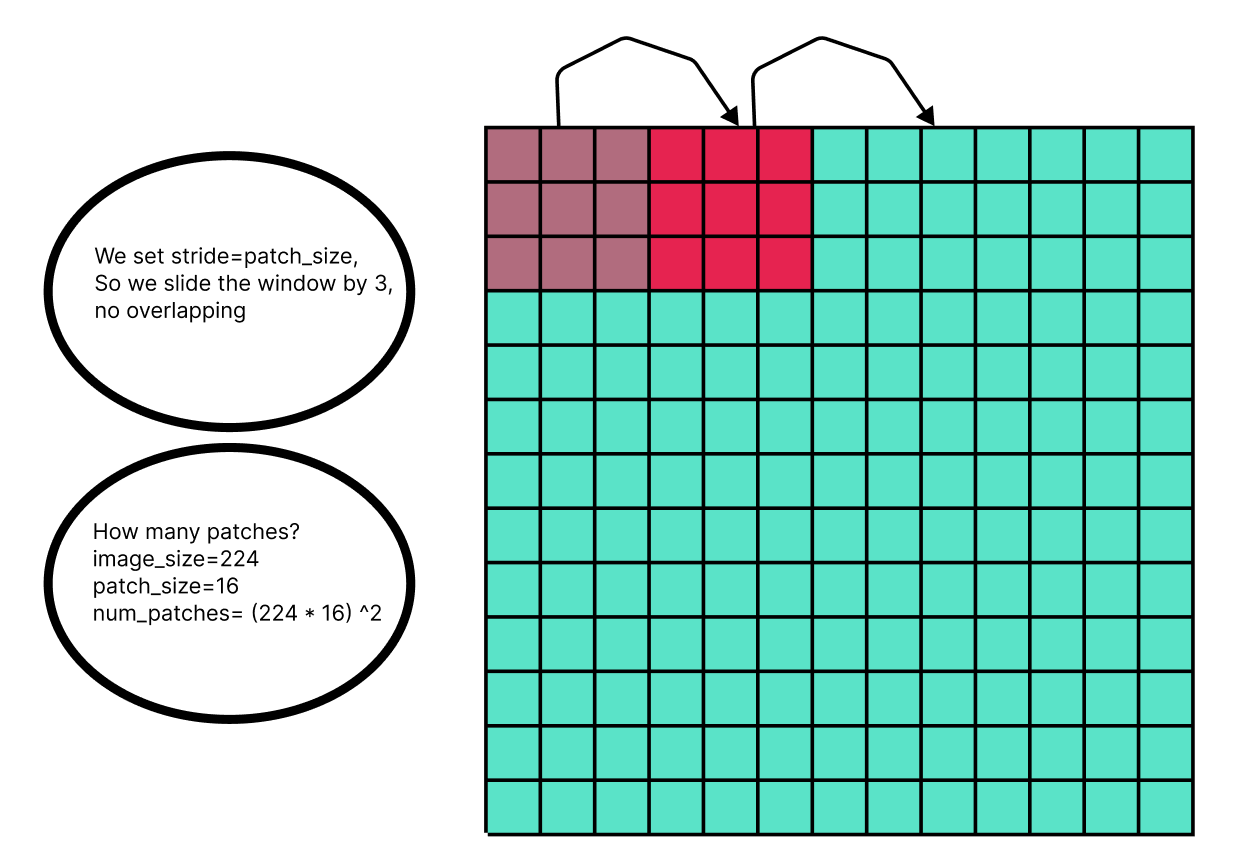

```python
    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        patch_embeds = self.patch_embedding(pixel_values)
        # Conv2d gives us information about the image in shape of
        # [BatchSize, EmbedDim, NumPatchesHeight, NumPatchesWidth]

        # we flat on 2nd index (NumPatchesHeight), we multiply index 2 and 3
        # tensor => [BatchSize, EmbedDim, NumPatchesHeight * NumPatchesWidth]

        # after that, we traspose index 1 and 2
        # tensor => [BatchSize, NumPatchesHeight * NumPatchesWidth, EmbedDim]
        embeddings = patch_embeds.flatten(2).transpose(1, 2)

        # Add position embeddings to each patch.
        # Each positional encoding is a vector of size [EmbedDim]
        embeddings += self.position_embedding(self.position_ids)

        return embeddings # [BatchSize, NumPatches, EmbedDim]
```

## SiglipAttention

In [ ]:
class SiglipAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.scale = self.head_dim**-0.5 # 1/sqrt(self.head_dim)
        self.dropout = config.attention_dropout

        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # [BatchSize, NumPatches, EmbedDim] : hidden_states
        BatchSize, NumPatches, _ = hidden_states.size()
        # NOTE: NumPatches was made of [NumPatchesHeight * NumPatchesWidth] in SiglipVisionEmbeddings

        # query_states: [BatchSize, NumPatches, EmbedDim]
        query_states = self.q_proj(hidden_states)
        # key_states: [BatchSize, NumPatches, EmbedDim]
        key_states = self.k_proj(hidden_states)
        # value_states: [BatchSize, NumPatches, EmbedDim]
        value_states = self.v_proj(hidden_states)

        # qkv_states: [BatchSize, NumPatches, NumHeads, HeadDim] -T-> [BatchSize, NumHeads, NumPatches, HeadDim]
        query_states = query_states.view(BatchSize, NumPatches, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = key_states.view(BatchSize, NumPatches, self.num_heads, self.head_dim).transpose(1, 2)
        value_states = value_states.view(BatchSize, NumPatches, self.num_heads, self.head_dim).transpose(1, 2)

        # Q * K^T / sqrt(d_k)
        # [BatchSize, NumHeads, NumPatches, NumPatches]
        attn_weights = (torch.matmul(query_states, key_states.transpose(2, 3)) * self.scale)

        if attn_weights.size() != (BatchSize, self.num_heads, NumPatches, NumPatches):
          raise ValueError(
            f"Attention weights should be of size({BatchSize, self.num_heads, NumPatches, NumPatches}),"
            f"but is {attn_weights.size()}"
          )

        # Apply the softmax row-wise. attn_weights: [BatchSize, NumHeads, NumPatches, NumPatches]
        attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)

        # Apply dropout only during training
        attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        ####
        # We would ask mask here if we would want to predict something
        # But we are working on images, we don't try to predict image
        # So we don't add masks to anything.
        ####

        # Multiply the attention weights by the value states, attn_output: [BatchSize, NumHeads, NumPatches, HeadDim]
        attn_output = torch.matmul(attn_weights, value_states)

        if attn_output.size() != (BatchSize, self.num_heads, NumPatches, NumPatches):
          raise ValueError(
            f"Attention output should be of size({BatchSize, self.num_heads, NumPatches, NumPatches}),"
            f"but is {attn_output.size()}"
          )

        # [BatchSize, NumHeads, NumPatches, HeadDim] -> [BatchSize, NumPatches, NumHeads, HeadDim]
        attn_output = attn_output.transpose(1, 2).contiguous()
        # contiguous: we want the tensor to represent the information memory in cotigues way

        # Concat heads
        attn_output = attn_output.reshape(BatchSize, NumPatches, self.embed_dim)
        # reshape is done without computational overhead because of contiguous

        # [BatchSize, NumPatches, EmbedDim]
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


- Authors didnot use masking for prompt and images.

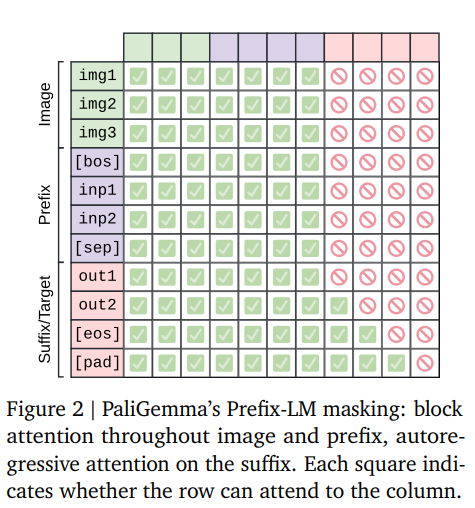

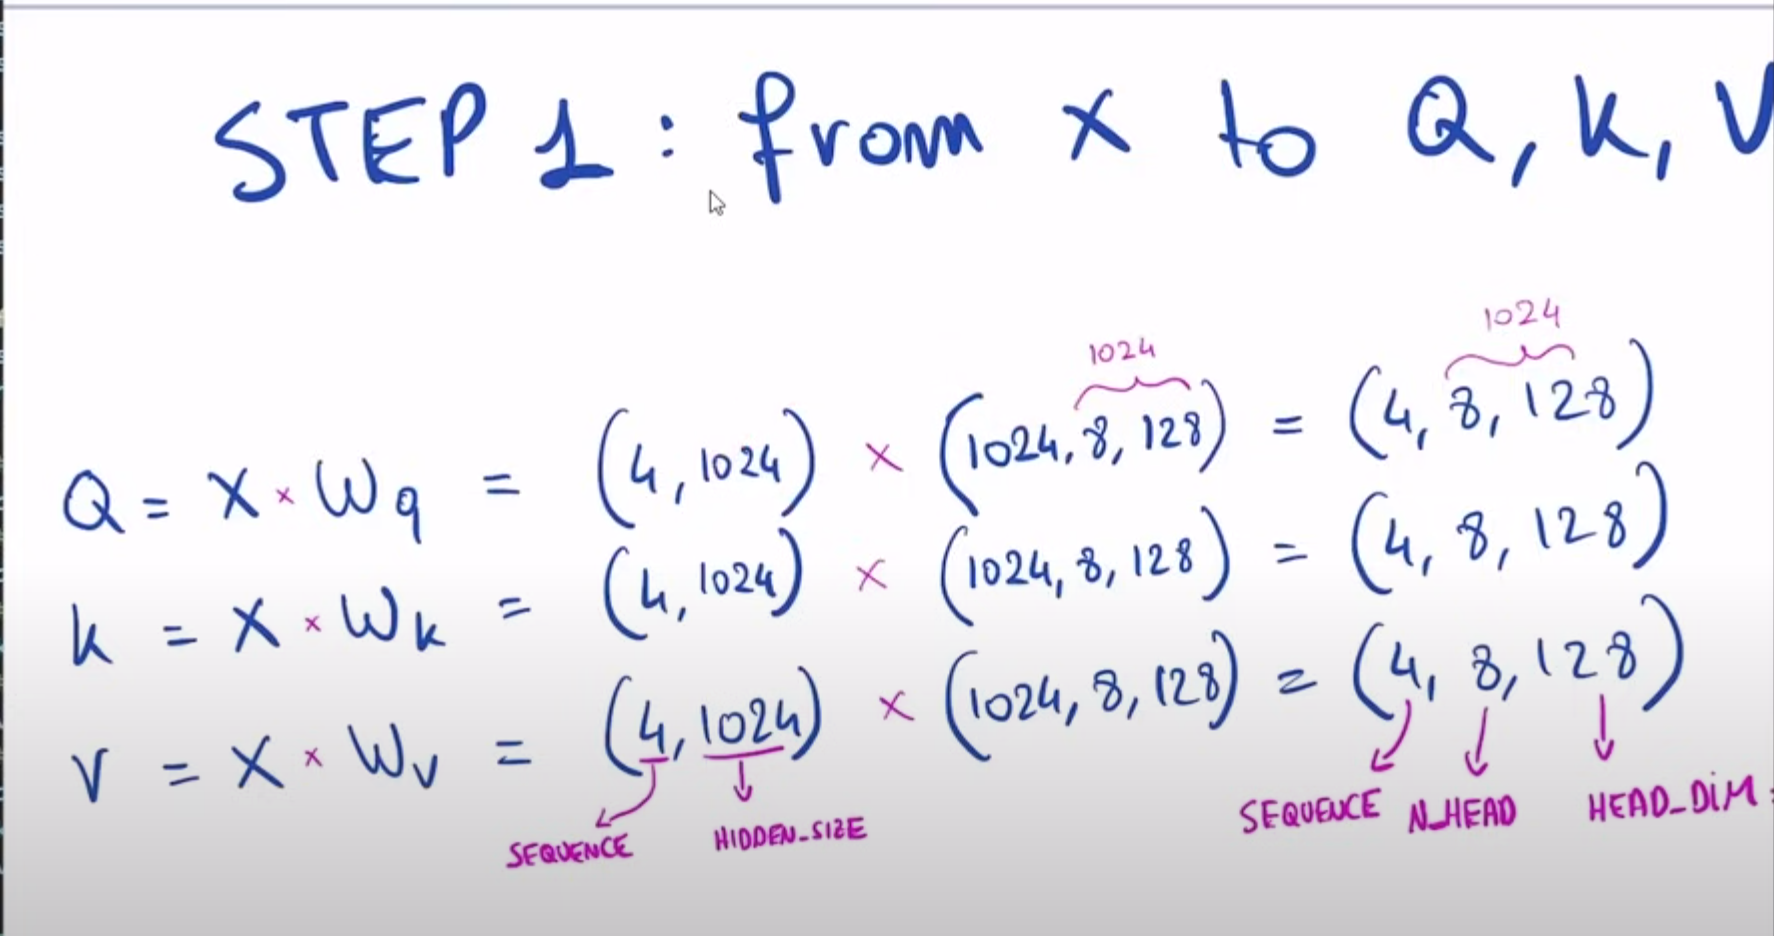

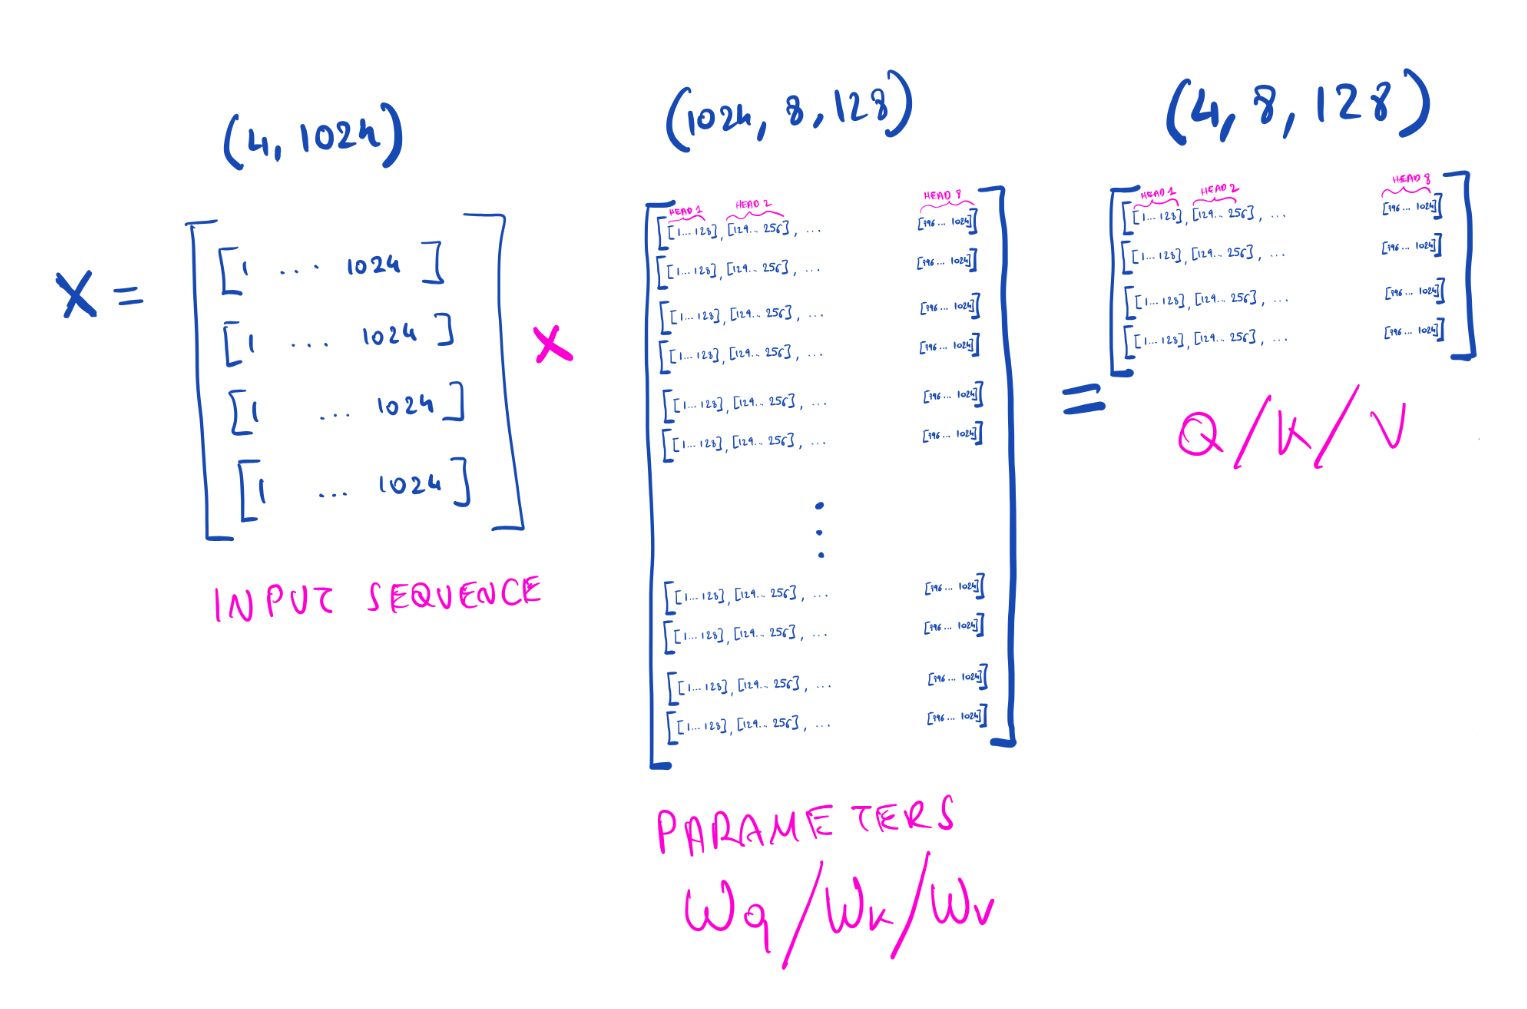

---
More detail for attention: [pdf](https://github.com/hkproj/pytorch-paligemma/blob/main/notes/Multi-Head%20Attention.pdf)

### Class Explanation

```python
def __init__()
    [...]
    self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
    self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)
```
- So each `proj` layer has same input and output shapes.


```python
def forward(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # [BatchSize, NumPatches, EmbedDim] : hidden_states
    BatchSize, NumPatches, _ = hidden_states.size()
    # NOTE: NumPatches was made of [NumPatchesHeight * NumPatchesWidth] in SiglipVisionEmbeddings
        
    # states: [BatchSize, NumPatches, EmbedDim]
    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

```
---
- For example, we send `query` that has shape (4, 1024) and nn.Linear() returns us (4, 1024).

```python
def forward(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # [BatchSize, NumPatches, EmbedDim] : hidden_states
    BatchSize, NumPatches, _ = hidden_states.size()
    # NOTE: NumPatches was made of [NumPatchesHeight * NumPatchesWidth] in SiglipVisionEmbeddings
        
    # states: [BatchSize, NumPatches, EmbedDim]
    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # qkv_states: [BatchSize, NumPatches, NumHeads, HeadDim] -T-> [BatchSize, NumAttnHeads, NumPatches, HeadDim]
    query_states = query_states.view(BatchSize, NumPatches, num_heads, head_dim).transpose(1, 2)
    key_states = key_states.view(BatchSize, NumPatches, num_heads, head_dim).transpose(1, 2)
    value_states = value_states.view(BatchSize, NumPatches, num_heads, head_dim).transpose(1, 2)
```
- We then convert those states into (4, 8, 128) shape using `.view()`.
- After that, transpose index 1 and 2, our states are shape `[BatchSize, NumAttnHeads, NumPatches, HeadDim]`
---

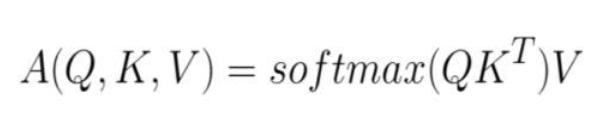

---
- We calculate attention

```python
    attn_weights = (torch.matmul(query_states, key_states.transpose(2, 3)) * self.scale)
    
    # Apply the softmax row-wise.
    # attn_weights: [BatchSize, NumHeads, NumPatches, NumPatches]
    attn_weights = nn.functional.softmax(attn_weights, dim=-1)

    # Apply dropout only during training
    attn_weights = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

    # Multiply the attention weights by the value states, attn_output: [BatchSize, NumHeads, NumPatches, HeadDim]
    attn_output = torch.matmul(attn_weights, value_states)
    return attn_output, attn_weights
```

---
**NOTE:** We didnt add masks because PaliGemma does not add masks to image and prompt, only masks the generated output.

---
- Finally, we transpose the attention and make it contiguous.

- **Why Transpose?**
    -  The tensor initially has the shape `[BatchSize, NumHeads, NumPatches, HeadDim]`
    - **BatchSize:** Number of input samples in the batch.
    - **NumHeads:** Number of attention heads (a common feature in multi-head self-attention).
    - **NumPatches:** Number of patches or tokens (i.e., sequence length).
    - **HeadDim:** Dimensionality of each attention head.

The tensor’s shape becomes `[BatchSize, NumPatches, NumHeads, HeadDim]`.
This transposition is typically done to prepare the data for further layers, like fully connected layers, which expect the sequence length **(NumPatches)** to be the second dimension. Transposing ensures that the attention output is in the correct format for processing downstream.

- **Why Contiguous?**
  - By calling `.contiguous()`, you ensure that the tensor is stored in a contiguous chunk of memory, meaning the data is re-arranged physically in memory so that it is laid out in a sequential order that is easier for the GPU or CPU to process efficiently.
---


**Why Multiply by 𝑊𝑜 ?**
- Each head learns different things, we need to concatinate those knowledge into one for more 'clever' model.
---

## SiglipMultiLayerPerceptron

In [ ]:
class SiglipMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # [BatchSize, NumPatches, EmbedDim] -> [BatchSize, NumPatches, EmbedDim]
        hidden_states = self.fc1(hidden_states)
        # hidden_states: [BatchSize, NumPatches, IntermediateSize]
        hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")
        # [BatchSize, NumPatches, EmbedDim]
        hidden_states = self.fc2(hidden_states)
        return hidden_states

- Attention mechanism is linear, it can only learn linear relationships, but if we add `non-linearity`, model can learn more complex things
* `fc1` and `fc2` layers will adapt themselves to data and learn

**What it does:**
- BatchSize, 196, 768 -> BatchSize, 196, 3072
- BatchSize, 196, 3072 -> BatchSize, 196, 768



## SiglipEncoderLayer

In [ ]:
class SiglipEncoderLayer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_att = SiglipAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # residual: [BatchSize, NumPatches, EmbedDim]
        residual = hidden_states

        # [BatchSize, NumPatches, EmbedDim] -> [BatchSize, NumPatches, EmbedDim]
        hidden_states = self.layer_norm1(hidden_states)
        # [BatchSize, NumPatches, EmbedDim] -> [BatchSize, NumPatches, EmbedDim]
        hidden_states, _ = self.self_attn(hidden_states=hidden_states)
        # [BatchSize, NumPatches, EmbedDim]
        hidden_states += residual

        residual = hidden_states

        # [BatchSize, NumPatches, EmbedDim] -> [BatchSize, NumPatches, EmbedDim]
        hidden_states = self.layer_norm1(hidden_states)
        # [BatchSize, NumPatches, EmbedDim] -> [BatchSize, NumPatches, EmbedDim]
        hidden_states = self.mlp(hidden_states)
        # [BatchSize, NumPatches, EmbedDim]
        hidden_states += residual

        return hidden_states

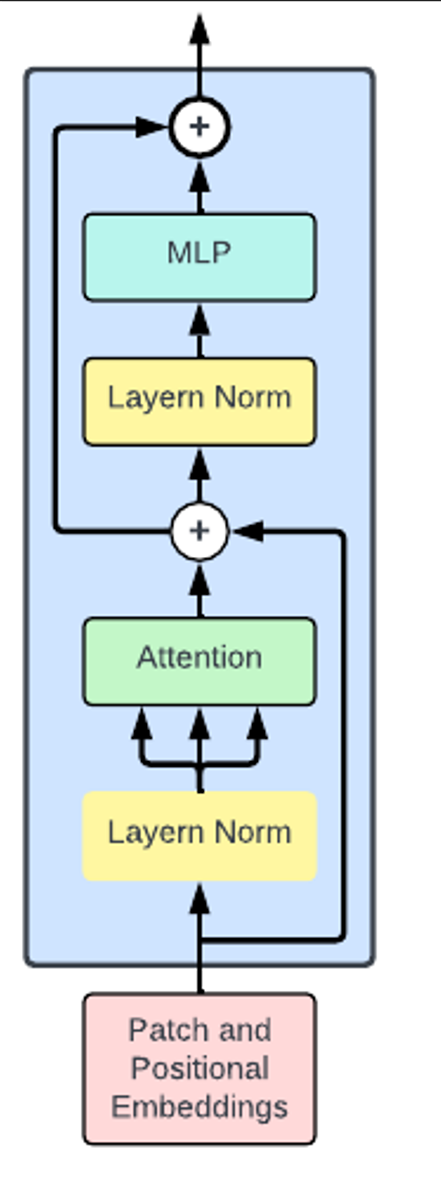

## SiglipEncoder

In [ ]:
class SiglipEncoder(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList(
            [SiglipEncoderLayer(config) for _ in range(config.num_hidden_layers)]
        )

    def forward(self, inputs_embeds: torch.Tensor) -> torch.Tensor:
        # inputs_embeds = [BatchSize, NumPatches, EmbedDim]
        for encoder_layer in self.layers:
            inputs_embeds = encoder_layer(inputs_embeds)
        return inputs_embeds

## SiglipVisionTransformer

In [ ]:
class SiglipVisionTransformer(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidde_size

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipEncoder(config)
        self.post_layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        # pixel_values
        # [BatchSize, Channel, Height, Width] -> [BatchSize, NumPatches, EmbedDim]

        hidden_states = self.embeddings(pixel_values)
        last_hidden_state = self.encoder(input_embeds=hidden_states)

        # We add one last Layer Normalization
        last_hidden_state = self.post_layernorm(last_hidden_state)
        return last_hidden_state

## SiglipVisionModel

In [ ]:
class SiglipVisionModel(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config
        self.vision_model = SiglipVisionTransformer(config)

    def forward(self, pixel_values) -> Tuple:
        # [BatchSize, Channel, Height, Width] -> [BatchSize, NumPatches, EmbedDim]
        return self.vision_model(pixel_values=pixel_values)